In [1]:
import os
import numpy as np
import pandas as pd
import skimage.io as skio
import skimage.measure as skim
import skimage.transform as skit

import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

2018-01-14 14:10:10,082 [pulse2percept] [INFO] Welcome to pulse2percept


In [39]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
X, y = p2pspatial.load_data(rootfolder, subject='12-005', electrodes=['E03'], amplitude=2.0)
X.shape

(10, 10)

# Load data

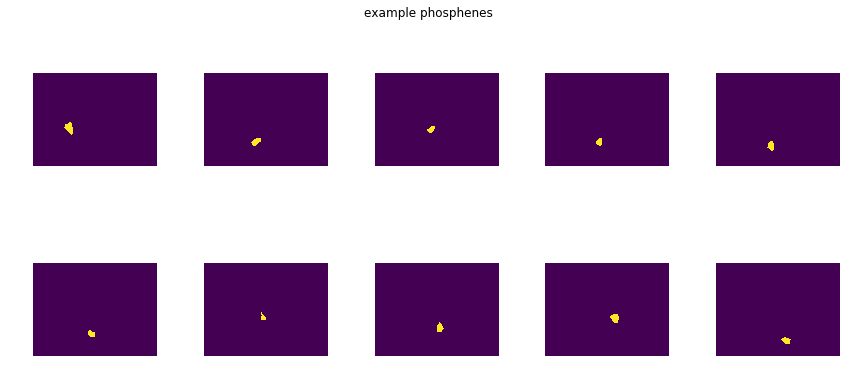

In [40]:
ncols = np.minimum(5, len(X))
nrows = int(np.ceil(len(X) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
for ax, Xrow in zip(axes.ravel(), X.iterrows()):
    _, row = Xrow
    ax.imshow(skio.imread(os.path.join(row['folder'], row['filename'])))
    ax.axis('image')
    ax.axis('off')
fig.suptitle('example phosphenes')
fig.tight_layout()

# Step 1: Center and scale phosphene

1a. Center both phosphenes in the image

1b. Scale the predicted phosphene so that it has the same area (`m[0, 0]`) of ground-truth phosphene

In [41]:
def center_phosphene(img_in):
    """Centers a phosphene in an image"""
    # Subtract center of mass from image center
    m = skim.moments(img_in, order=1)
    transl = (img_in.shape[1] // 2 - m[1, 0] / m[0, 0],
              img_in.shape[0] // 2 - m[0, 1] / m[0, 0])
    return skit.warp(img_in, skit.SimilarityTransform(translation=transl).inverse)

In [42]:
def center_scale_phosphene(img_truth, img_pred):
    """Center and scale a phosphene in `img_pred` to the size of `img_truth`"""
    assert np.allclose(img_truth.shape, img_pred.shape)
    img_truth = center_phosphene(img_truth)
    img_pred = center_phosphene(img_pred)
    
    # Scale phosphene in `img_pred` to area of phosphene in `img_truth`
    area_truth = skim.moments(img_truth, order=0)[0, 0]
    area_pred = skim.moments(img_pred, order=0)[0, 0]
    scale = area_truth / area_pred

    # Shift the phosphene to (0, 0), scale, shift back to the image center
    shift_y, shift_x = np.array(img_pred.shape[:2]) / 2.0
    tf_shift = skit.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_scale = skit.SimilarityTransform(scale=scale)
    tf_shift_inv = skit.SimilarityTransform(translation=[shift_x, shift_y])
    return skit.warp(img_pred, (tf_shift + (tf_scale + tf_shift_inv)).inverse)

In [43]:
img0 = skio.imread(os.path.join(X.loc[0, 'folder'], X.loc[0, 'filename']))
img1 = skio.imread(os.path.join(X.loc[1, 'folder'], X.loc[1, 'filename']))

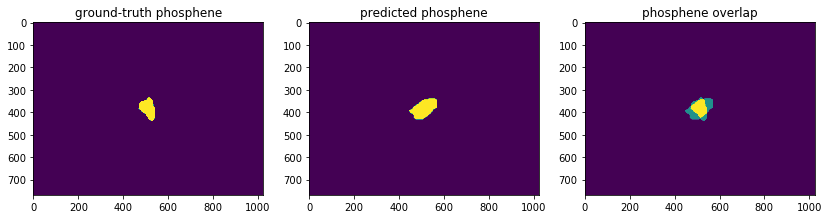

In [44]:
# pretend `img0` is the ground-truth phosphene
img_true = center_phosphene(img0)

# pretend `img` is the predicted phosphene
img_pred = center_scale_phosphene(img0, img1)

plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_true)
plt.title('ground-truth phosphene')

plt.subplot(132)
plt.imshow(img_pred)
plt.title('predicted phosphene')

plt.subplot(133)
plt.imshow(img_true + img_pred)
plt.title('phosphene overlap')

# Step 2: Find best rotation using dice coefficient

Now that both phosphenes are centered and have the same area, find the rotation angle that gives the best phosphene overlap (measured with the dice coefficient).

In [45]:
def dice_coeff(img0, img1):
    """Compute dice coefficient"""
    img0 = img0 > 0
    img1 = img1 > 0
    return 2 * np.sum(img0 * img1) / (np.sum(img0) + np.sum(img1))

(-90.0, 0.76310018903591681)

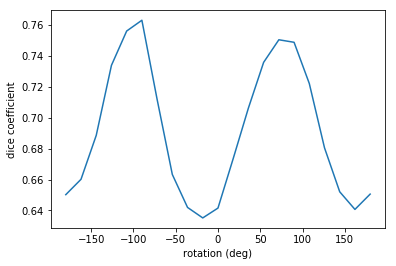

In [70]:
rot = np.linspace(-180, 180, 21)
dice = [dice_coeff(img_true, skit.rotate(img_pred, r)) for r in rot]
plt.plot(rot, dice)
plt.xlabel('rotation (deg)')
plt.ylabel('dice coefficient')
rot[np.argmax(dice)], np.max(dice)

It's possible to get multiple angles with the same max dice coefficient: Choose the smallest rotation angle.

In [47]:
print('Best angle:', np.abs(rot[np.isclose(dice, np.max(dice))]).min(), 'deg')

Best angle: 100.8 deg


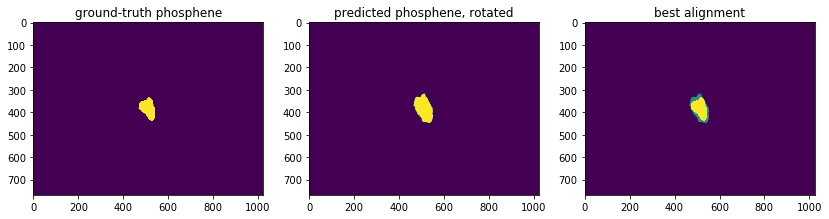

In [48]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_true)
plt.title('ground-truth phosphene')
plt.subplot(132)
plt.title('predicted phosphene, rotated')
plt.imshow(skit.rotate(img_pred, rot[np.argmax(dice)]))
plt.subplot(133)
plt.title('best alignment')
plt.imshow(img_true + skit.rotate(img_pred, rot[np.argmax(dice)]))

# Putting it all together

In [49]:
def scale_phosphene(img, scale):
    """Scales phosphene with a scaling factor"""
    # Shift the phosphene to (0, 0), scale, shift back to the image center
    shift_y, shift_x = np.array(img.shape[:2]) / 2.0
    tf_shift = skit.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_scale = skit.SimilarityTransform(scale=scale)
    tf_shift_inv = skit.SimilarityTransform(translation=[shift_x, shift_y])
    return skit.warp(img, (tf_shift + (tf_scale + tf_shift_inv)).inverse)

In [88]:
import scipy.interpolate as spi
def loss(img_true, img_pred, w_deg=1):
    """Calculate loss function"""
    img_true = center_phosphene(img_true)
    img_pred = center_phosphene(img_pred)
    
    # Scale phosphene in `img_pred` to area of phosphene in `img_truth`
    area_true = skim.moments(img_true, order=0)[0, 0]
    area_pred = skim.moments(img_pred, order=0)[0, 0]
    scale = area_true / area_pred
    img_pred = scale_phosphene(img_pred, scale)
    
    # Rotate the phosphene so that dice coefficient is maximized
    angles = np.linspace(-180, 180, 101)
    dice = [dice_coeff(img_true, skit.rotate(img_pred, r)) for r in angles]
    rot_deg = np.abs(angles[np.isclose(dice, np.max(dice))]).min()
    
    return scale + w_deg * rot_deg - np.max(dice)

In [89]:
loss(img0, img0)

0.0

In [90]:
loss(img0, img1)

90.752172874833263

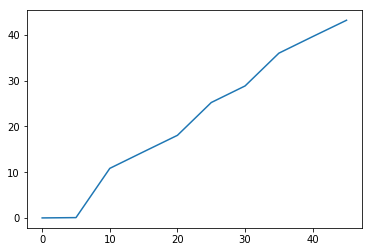

In [96]:
angles = np.arange(0, 46, 5)
plt.plot(angles, [loss(img0, skit.rotate(img0, a)) for a in angles])

In [95]:
for r in [1, 10, 35]:
    print(loss(img0, skit.rotate(img0, r)), loss(img0, skit.rotate(img0, -r)))

0.0515137619723 0.0229198675903
10.8393921209 10.8684978427
36.0419551201 32.4702446391
